In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import sklearn.metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn import svm
import xgboost as xgb

In [2]:
train_historic = pd.read_csv('./cfb_15_21_train_wide.csv')
test_historic = pd.read_csv('./cfb_15_21_test_wide.csv')
week4 = pd.read_csv('./w4_data.csv')
# train_historic.columns

Data Prep

In [3]:
# Add the h_ suffix
train_historic['h_drives'] = train_historic['drives']
train_historic['h_d_explosiveness']= train_historic['d_explosiveness'] 
train_historic['h_d_successrate']= train_historic['d_successrate']
train_historic['h_d_stuffrate']= train_historic['d_stuffrate']
train_historic['h_d_totalPPA']= train_historic['d_totalPPA']
train_historic['h_o_explosiveness']= train_historic['o_explosiveness'] 
train_historic['h_o_successrate']= train_historic['o_successrate']
train_historic['h_o_stuffrate']= train_historic['o_stuffrate']
train_historic['h_o_totalPPA']= train_historic['o_totalPPA']
train_historic['home_team_cover_spread'] = train_historic['home_team_cover_spread']

In [4]:
# Add the h_ suffix
test_historic['h_drives'] = test_historic['drives']
test_historic['h_d_explosiveness']= test_historic['d_explosiveness'] 
test_historic['h_d_successrate']= test_historic['d_successrate']
test_historic['h_d_stuffrate']= test_historic['d_stuffrate']
test_historic['h_d_totalPPA']= test_historic['d_totalPPA']
test_historic['h_o_explosiveness']= test_historic['o_explosiveness'] 
test_historic['h_o_successrate']= test_historic['o_successrate']
test_historic['h_o_stuffrate']= test_historic['o_stuffrate']
test_historic['h_o_totalPPA']= test_historic['o_totalPPA']
test_historic['home_team_cover_spread'] = test_historic['home_team_cover_spread']

In [5]:
# Downselect to apprpriate variables
train_historic = train_historic[week4.columns]
test_historic = test_historic[week4.columns]


In [6]:
train_historic_y = train_historic['home_team_cover_spread']
train_historic_x = train_historic.drop('home_team_cover_spread', axis=1)
train_historic_x = train_historic_x.drop('Unnamed: 0', axis=1)

In [7]:
test_historic_y = test_historic['home_team_cover_spread']
test_historic_x = test_historic.drop('home_team_cover_spread', axis=1)
test_historic_x = test_historic_x.drop('Unnamed: 0', axis=1)

In [8]:
# Define Helper Fucntion for NN
def get_mlp_model(hiddenLayerOne=784, hiddenLayerTwo=256,
	dropout=0.2, learnRate=0.01):
	# initialize a sequential model and add layer to flatten the
	# input data
	model = Sequential()
	model.add(Flatten())
 	# add two stacks of FC => RELU => DROPOUT
	model.add(Dense(hiddenLayerOne, activation="relu",
		input_shape=(784,)))
	model.add(Dropout(dropout))
	model.add(Dense(hiddenLayerTwo, activation="relu"))
	model.add(Dropout(dropout))
	# add a softmax layer on top
	model.add(Dense(10, activation="softmax"))
	# compile the model
	model.compile(
		optimizer=Adam(learning_rate=learnRate),
		loss="sparse_categorical_crossentropy",
		metrics=["accuracy"])
	# return compiled model
	return model

In [9]:
# Set SVM Kernel
kernel = 'linear'

In [10]:
dt = tree.DecisionTreeClassifier()
boostgrb = GradientBoostingClassifier()
nn = KerasClassifier(build_fn=get_mlp_model, verbose=0)
kn = knn(n_neighbors=3)
sv = svm.SVC(kernel=kernel, probability=True)
xgrb = xgb.XGBClassifier()

C:\Users\magamp\AppData\Local\Temp\ipykernel_11756\3953798795.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=get_mlp_model, verbose=0)


In [11]:
# Set up fpr comparison
models = []
models.append(('Tree',dt))
models.append(('Boost', boostgrb))
models.append(('KNN', kn))
models.append(('NN', nn))
models.append(('SVM', sv))
models.append(('XGBoost', xgrb))

In [12]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
seed = 42

In [13]:
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed, shuffle=True)
	cv_results = model_selection.cross_val_score(model, train_historic_x, train_historic_y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
 # runtime ~.5m

Tree: 0.704780 (0.019979)
Boost: 0.791726 (0.012567)
KNN: 0.617095 (0.015341)
26/26 [==============================] - 0s 1ms/step
NN: 0.545081 (0.096376)
SVM: 0.802692 (0.013664)
XGBoost: 0.782013 (0.017978)


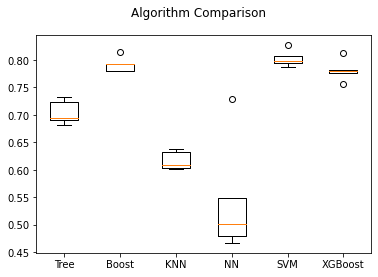

In [14]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [16]:
dt.fit(train_historic_x,train_historic_y)
boostgrb.fit(train_historic_x,train_historic_y) 
kn.fit(train_historic_x,train_historic_y) 
sv.fit(train_historic_x,train_historic_y)  
xgrb.fit(train_historic_x,train_historic_y)
nn.fit(train_historic_x,train_historic_y) 
# About 47 seconds to fit all 

In [23]:
import pickle

In [109]:
# pickle.dump(xgrb, open('../Models1521/xbg_cfb.sav', 'wb'))

PREDICTING NEXT WEEKS GAMES

In [25]:
nextgames = pd.read_csv('./w4_not_yet_played.csv')
p_df_h = pd.read_csv('./week4_matchups.csv')

In [26]:
nextgames = nextgames.drop('Unnamed: 0', axis=1)

In [27]:
track = []
for name, model in models:
    preds = model.predict(nextgames)
    track.append(preds)

2/2 [==============================] - 0s 2ms/step


In [28]:
p_df_h['dt_preds'] = track[0]
p_df_h['boost_preds'] = track[1]
p_df_h['knn_preds'] = track[2]
p_df_h['nn_preds'] = track[3]
p_df_h['svm_preds'] = track[4]
p_df_h['xgb_preds'] = track[5]

CFB Week 4 Predictions!

In [29]:
p_df_h.sort_values('home_team')

,home_team,away_team,spread,dt_preds,boost_preds,knn_preds,nn_preds,svm_preds,xgb_preds
3,Air Force,Nevada,-24.0,0,0,1,1,0,0
50,Alabama,Vanderbilt,-40.0,1,0,0,1,0,0
26,Appalachian State,James Madison,-7.0,1,1,1,1,1,1
58,Arizona State,Utah,14.5,1,1,1,0,1,1
9,Auburn,Missouri,-7.0,1,1,0,1,1,1
56,BYU,Wyoming,-22.0,0,0,1,1,0,0
31,California,Arizona,-3.0,1,1,1,1,1,1
21,Cincinnati,Indiana,-17.0,0,0,1,1,0,0
16,Colorado,UCLA,21.5,1,1,1,0,1,1
34,East Carolina,Navy,-17.0,0,0,0,1,0,0


Hyperparameter Tuning / Model Optimization Using Historic Data
    - 2021 matchups are Test Data
    - 2015-2020 matchups are Training Data

Data Set Up - Should be good to go

In [30]:
train_historic_x
train_historic_y
test_historic_x
test_historic_y

0      1
1      1
2      1
3      0
4      0
      ..
725    1
726    0
727    0
728    1
729    1
Name: home_team_cover_spread, Length: 730, dtype: int64

KNN Tuning

In [31]:
accuracy = []

# Calculating MAE error for K values between 1 and 39
for i in range(1, 70):
    nkn = knn(n_neighbors=i)
    nkn.fit(train_historic_x, train_historic_y)
    pred_i = nkn.predict(test_historic_x)
    acc = accuracy_score(test_historic_y, pred_i)
    accuracy.append(acc)

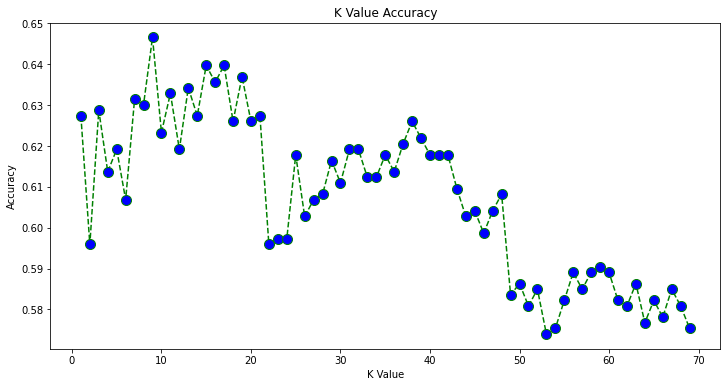

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 70), accuracy, color='green', 
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
         
plt.title('K Value Accuracy')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.show()

In [33]:
accuracy[8:11]

[0.6465753424657534, 0.6232876712328768, 0.6328767123287671]

Optimal K value appears to be 9!

In [34]:
opt_k = knn(n_neighbors=9)
opt_k.fit(train_historic_x,train_historic_y)

KNeighborsClassifier(n_neighbors=9)

In [35]:
opt_k.score(train_historic_x,train_historic_y)

0.723716990533134

In [36]:
opt_k.score(test_historic_x, test_historic_y)

0.6465753424657534

In [37]:
opt_k_preds = opt_k.predict(test_historic_x)
cm = confusion_matrix(test_historic_y, opt_k_preds)
cm

array([[239, 118],
       [140, 233]], dtype=int64)

[Text(0, 0.5, 'Did Cover'), Text(0, 1.5, 'Did Not Cover')]

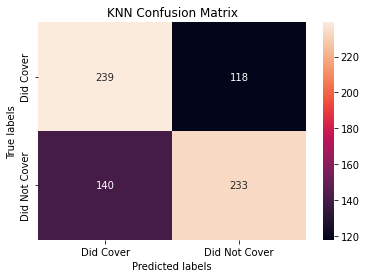

In [38]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('KNN Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Did Cover', 'Did Not Cover']); ax.yaxis.set_ticklabels(['Did Cover', 'Did Not Cover'])

SVM Tuning

In [39]:
# initialize model and define the space of the hyperparameters to
# perform the grid-search over
model = sv
kernel = ["linear"]
tolerance = [1e-4, 1e-5, 1e-6]
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]

grid = dict(kernel=kernel, tol=tolerance, C=C, gamma=gamma)


In [40]:
# initialize a cross-validation fold and perform a grid-search to
# tune the hyperparameters
# print("[INFO] grid searching over the hyperparameters...")
# cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# gridSearch = GridSearchCV(estimator=svm.SVC(), param_grid=grid, n_jobs=-1,
# 	cv=cvFold, scoring='accuracy')
# searchResults = gridSearch.fit(train_historic_x, train_historic_y)

In [41]:
sv.score(train_historic_x,train_historic_y)

0.806925759840558

In [42]:
sv.score(test_historic_x,test_historic_y)

0.8315068493150685

In [43]:
sv_preds = sv.predict(test_historic_x)
cm = confusion_matrix(test_historic_y, sv_preds)
cm

array([[300,  57],
       [ 66, 307]], dtype=int64)

[Text(0, 0.5, 'Did Cover'), Text(0, 1.5, 'Did Not Cover')]

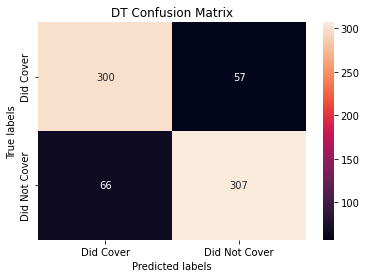

In [44]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('DT Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Did Cover', 'Did Not Cover']); ax.yaxis.set_ticklabels(['Did Cover', 'Did Not Cover'])

Looks like the orignial SV was the best

In [48]:
pickle.dump(sv, open('../Models1521/sv_cfb1.sav', 'wb'))

Tree Tuning

In [49]:
dt = tree.DecisionTreeClassifier()
dt.fit(train_historic_x,train_historic_y)
dt_preds = dt.predict(test_historic_x)
confusion_matrix(test_historic_y,dt_preds)

array([[247, 110],
       [106, 267]], dtype=int64)

In [50]:
from sklearn.metrics import roc_curve, auc , accuracy_score
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_historic_y, dt_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


0.7038472225351267

In [51]:
max_depths = np.arange(1, 33, 1)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = tree.DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(train_historic_x, train_historic_y)
   train_pred = dt.predict(train_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_historic_y, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(test_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_historic_y, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

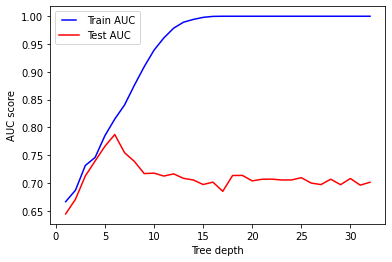

In [52]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Optimal Tree has Depth of 6

In [53]:
dt_opt = tree.DecisionTreeClassifier(max_depth=6)

In [54]:
dt_opt.fit(train_historic_x, train_historic_y)

DecisionTreeClassifier(max_depth=6)

In [55]:
pickle.dump(dt_opt, open('../Models1521/dt_cfb1.sav', 'wb'))

In [56]:
dt_opt_preds = dt_opt.predict(test_historic_x)
cm = confusion_matrix(test_historic_y, dt_opt_preds)

[Text(0, 0.5, 'Did Cover'), Text(0, 1.5, 'Did Not Cover')]

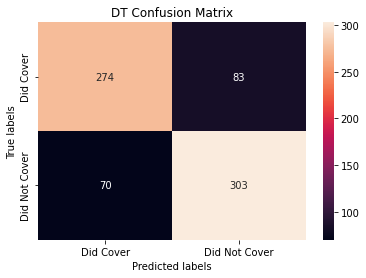

In [57]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('DT Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Did Cover', 'Did Not Cover']); ax.yaxis.set_ticklabels(['Did Cover', 'Did Not Cover'])

In [58]:
dt.score(train_historic_x,train_historic_y)

1.0

In [59]:
dt.score(test_historic_x,test_historic_y)

0.7013698630136986

In [60]:
dt_opt.score(train_historic_x,train_historic_y)

0.8146487294469357

In [61]:
dt_opt.score(test_historic_x,test_historic_y)

0.7904109589041096

Gradient Boosting Tuning

In [62]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []

In [65]:
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(train_historic_x, train_historic_y)
   train_pred = model.predict(train_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_historic_y, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(test_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_historic_y, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

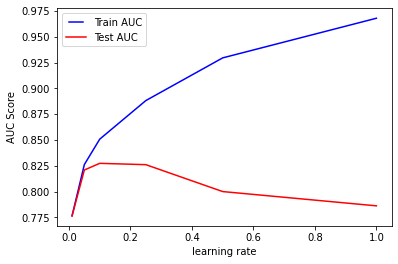

In [66]:
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('learning rate')
plt.show()

If learning rate is too high we get over fitting

In [67]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 80, 100]
train_results = []
test_results = []

In [69]:
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(train_historic_x, train_historic_y)
   train_pred = model.predict(train_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_historic_y, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(test_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_historic_y, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

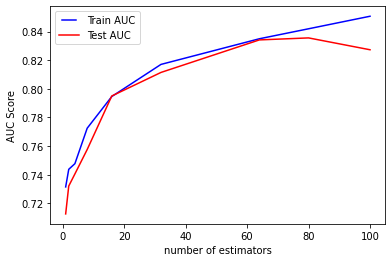

In [70]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('number of estimators')
plt.show()

It looks like we can get our best results without over fitting using about 60 estimators

In [71]:
max_depths = np.arange(1, 32)
train_results = []
test_results = []

In [72]:
for md in max_depths:
   model = GradientBoostingClassifier(max_depth=md)
   model.fit(train_historic_x, train_historic_y)
   train_pred = model.predict(train_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_historic_y, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(test_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_historic_y, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [73]:
test_results[:5]

[0.7948423337163283,
 0.8304158124375756,
 0.8273143037375809,
 0.8273743813879438,
 0.8166505207981315]

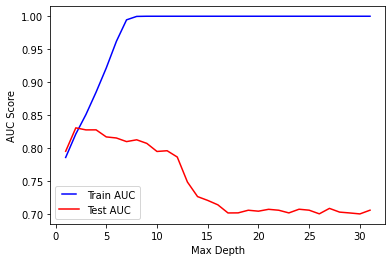

In [74]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Max Depth')
plt.show()

Best depth looks like 2-4 range

In [75]:
min_samples_splits = np.arange(0.1, 1.0, 0.1)
train_results = []
test_results = []

In [77]:
for ms in min_samples_splits:
   model = GradientBoostingClassifier(min_samples_split=ms)
   model.fit(train_historic_x, train_historic_y)
   train_pred = model.predict(train_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_historic_y, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(test_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_historic_y, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [78]:
min_samples_splits[:5]

array([0.1, 0.2, 0.3, 0.4, 0.5])

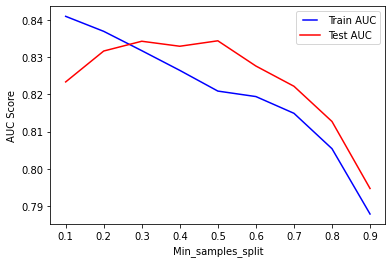

In [79]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Min_samples_split')
plt.show()

0.5 samples required to split an internal node looks to be the optimal setting for test data.

In [80]:
min_samples_leafs = np.arange(0.1, 0.5, 0.1)
train_results = []
test_results = []

In [81]:
for ms in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=ms)
   model.fit(train_historic_x, train_historic_y)
   train_pred = model.predict(train_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_historic_y, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(test_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_historic_y, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

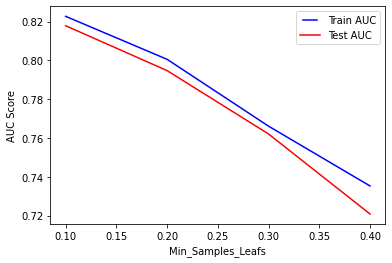

In [82]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Min_Samples_Leafs')
plt.show()

Keeping the minimum samples in the leafs node low produces best results across both train and test sets.

In [83]:
max_features = list(range(1,train_historic_x.shape[1]))
train_results = []
test_results = []

In [84]:
for mf in max_features:
   model = GradientBoostingClassifier(max_features=mf)
   model.fit(train_historic_x, train_historic_y)
   train_pred = model.predict(train_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_historic_y, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(test_historic_x)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_historic_y, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

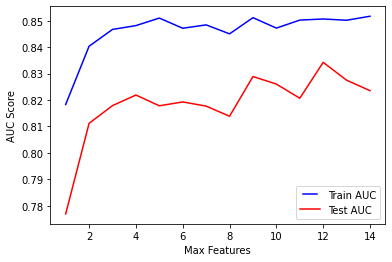

In [85]:
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Max Features')
plt.show()

We definitely want to include all features!

In [87]:
opt_boost = GradientBoostingClassifier(learning_rate=0.1, 
                max_depth=2,
                min_samples_leaf=0.1,
                min_samples_split=0.5, 
                n_estimators=60)
opt_boost.fit(train_historic_x, train_historic_y)


GradientBoostingClassifier(max_depth=2, min_samples_leaf=0.1,
                           min_samples_split=0.5, n_estimators=60)

In [88]:
pickle.dump(opt_boost, open('../Models1521/boost_cfb1.sav', 'wb'))

In [89]:
opt_boost.score(train_historic_x, train_historic_y)

0.7957149975087194

In [90]:
opt_boost.score(test_historic_x,test_historic_y)

0.7945205479452054

In [91]:
opt_boost_preds = opt_boost.predict(test_historic_x)
cm =confusion_matrix(test_historic_y,opt_boost_preds)
cm

array([[289,  68],
       [ 82, 291]], dtype=int64)

[Text(0, 0.5, 'Did Cover'), Text(0, 1.5, 'Did Not Cover')]

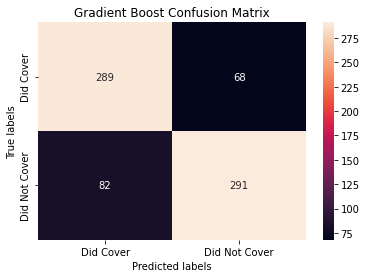

In [92]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Gradient Boost Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Did Cover', 'Did Not Cover']); ax.yaxis.set_ticklabels(['Did Cover', 'Did Not Cover'])

Neural Net Tuning

In [93]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [256, 512, 784]
hiddenLayerTwo = [128, 256, 512]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32]
epochs = [10, 20, 30, 40]

In [94]:
# create a dictionary from the hyperparameter grid
grid = dict(
	hiddenLayerOne=hiddenLayerOne,
	learnRate=learnRate,
	hiddenLayerTwo=hiddenLayerTwo,
	dropout=dropout,
	batch_size=batchSize,
	epochs=epochs
)

In [95]:
print("[INFO] performing random search...")
searcher = RandomizedSearchCV(estimator=nn, n_jobs=-1, cv=5,
	param_distributions=grid, scoring="accuracy")
searchResults = searcher.fit(train_historic_x, train_historic_y)

[INFO] performing random search...


In [96]:
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
	bestParams))

[INFO] best score is 0.51 using {'learnRate': 0.001, 'hiddenLayerTwo': 128, 'hiddenLayerOne': 784, 'epochs': 20, 'dropout': 0.3, 'batch_size': 16}


In [97]:
def get_mlp_model2(hiddenLayerOne=256, hiddenLayerTwo=256,
	dropout=0.4, learnRate=0.001):
	# initialize a sequential model and add layer to flatten the
	# input data
	model = Sequential()
	model.add(Flatten())
 	# add two stacks of FC => RELU => DROPOUT
	model.add(Dense(hiddenLayerOne, activation="relu",
		input_shape=(784,)))
	model.add(Dropout(dropout))
	model.add(Dense(hiddenLayerTwo, activation="relu"))
	model.add(Dropout(dropout))
	# add a softmax layer on top
	model.add(Dense(10, activation="softmax"))
	# compile the model
	model.compile(
		optimizer=Adam(learning_rate=learnRate),
		loss="sparse_categorical_crossentropy",
		metrics=["accuracy"])
	# return compiled model
	return model

In [98]:
nnTune = KerasClassifier(build_fn=get_mlp_model2, verbose=None)
H = nnTune.fit(train_historic_x,train_historic_y, validation_data = (test_historic_x, test_historic_y) ,batch_size = 16, epochs=40)

C:\Users\magamp\AppData\Local\Temp\ipykernel_32488\3502779952.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nnTune = KerasClassifier(build_fn=get_mlp_model2, verbose=None)


In [99]:
scores = nnTune.model.evaluate(train_historic_x,train_historic_y)
scores

126/126 [==============================] - 0s 1ms/step - loss: 0.4647 - accuracy: 0.7621


[0.464662104845047, 0.7620826959609985]

In [100]:
scores = nnTune.model.evaluate(test_historic_x,test_historic_y)
scores

23/23 [==============================] - 0s 1ms/step - loss: 0.4580 - accuracy: 0.7740


[0.45802605152130127, 0.7739726305007935]

In [101]:
nnTune_preds = nnTune.predict(test_historic_x)
cm =confusion_matrix(test_historic_y,nnTune_preds)
cm

23/23 [==============================] - 0s 954us/step


array([[336,  21],
       [144, 229]], dtype=int64)

[Text(0, 0.5, 'Did Cover'), Text(0, 1.5, 'Did Not Cover')]

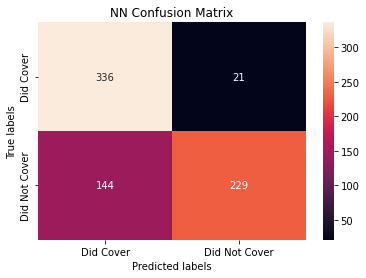

In [102]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('NN Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Did Cover', 'Did Not Cover']); ax.yaxis.set_ticklabels(['Did Cover', 'Did Not Cover'])

More Cross Validation and Assessment of Test performance 

In [103]:
# Define function for assessing the models
def modelfit(alg, trainx, trainy, testx, testy, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(trainx, trainy)
        
    #Predict training set:
    predictions = alg.predict(testx)
    predprob = alg.predict_proba(testx)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, trainx, trainy, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % sklearn.metrics.accuracy_score(testy, predictions))
    print ("AUC Score (Test): %f" % sklearn.metrics.roc_auc_score(testy, predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, trainx.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    else:
        pass


Model Report
Accuracy : 0.8151
AUC Score (Test): 0.892529
CV Score : Mean - 0.8551016 | Std - 0.01412685 | Min - 0.833203 | Max - 0.8768074


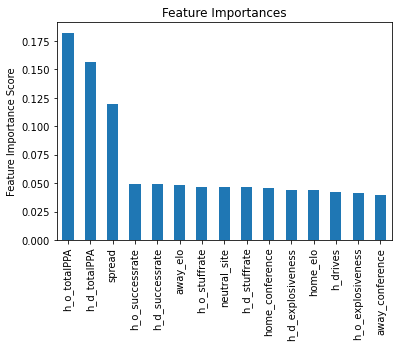

In [107]:
modelfit(xgrb,train_historic_x,train_historic_y,test_historic_x,test_historic_y)


Model Report
Accuracy : 0.789
AUC Score (Test): 0.843817
CV Score : Mean - 0.8145399 | Std - 0.01881431 | Min - 0.7945861 | Max - 0.8484294


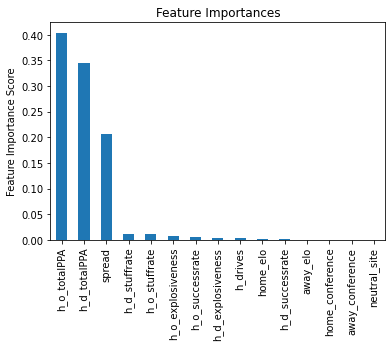

In [104]:
modelfit(dt_opt, train_historic_x, train_historic_y, test_historic_x, test_historic_y)


Model Report
Accuracy : 0.8274
AUC Score (Test): 0.902276
CV Score : Mean - 0.8775599 | Std - 0.01245852 | Min - 0.8633532 | Max - 0.9003202


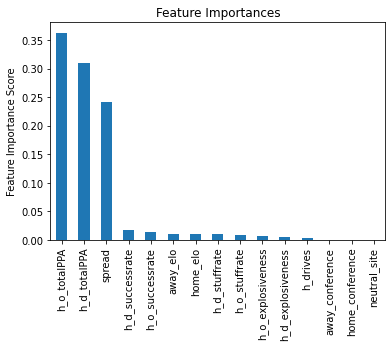

In [106]:
modelfit(boostgrb, train_historic_x, train_historic_y, test_historic_x, test_historic_y)

In [ ]:
modelfit(sv, train_historic_x, train_historic_y, test_historic_x, test_historic_y, printFeatureImportance=False)

In [ ]:
modelfit(kn, train_historic_x, train_historic_y, test_historic_x, test_historic_y, printFeatureImportance = False)

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")
modelfit(nnTune, train_historic_x, train_historic_y, test_historic_x, test_historic_y, printFeatureImportance = False)

LEARNING CURVES

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = "Learning Curves " + str(nnTune)
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(
    nnTune,
    title,
    train_historic_x,
    train_historic_y,
    axes=axes[:, 0],
    ylim=(0.3, 1.01),
    cv=5,
    n_jobs=4,
    scoring="accuracy",
)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = "Learning Curves Gradient Boosting" 
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(
    opt_boost,
    title,
    train_historic_x,
    train_historic_y,
    axes=axes[:, 0],
    ylim=(0.5, 1.01),
    cv=5,
    n_jobs=4,
    scoring="accuracy",
)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = "Learning Curves " + "Decision Tree"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(
    dt_opt,
    title,
    train_historic_x,
    train_historic_y,
    axes=axes[:, 0],
    ylim=(0.5, 1.01),
    cv=5,
    n_jobs=4,
    scoring="accuracy",
)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = "Learning Curves " + "KNN"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(
    opt_k,
    title,
    train_historic_x,
    train_historic_y,
    axes=axes[:, 0],
    ylim=(0.5, 1.01),
    cv=5,
    n_jobs=4,
    scoring="accuracy",
)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = "Learning Curves " + "SVM"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(
    sv,
    title,
    train_historic_x,
    train_historic_y,
    axes=axes[:, 0],
    ylim=(0.5, 1.01),
    cv=5,
    n_jobs=4,
    scoring="accuracy",
)